In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline
import sys
sys.path.append("..")   # add parent directory to Python path
import functions

voltage = functions.load_voltage('../data/tau_d_0.408_temporal_APD_step_4 (1).csv')
APD,DI,BCL = functions.get_APD_DI_BCL([voltage])

In [2]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

df = voltage[:2000]
p_length = 1000

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df),
    prediction_length=p_length,
    quantile_levels=[0.1, 0.5, 0.9],
)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


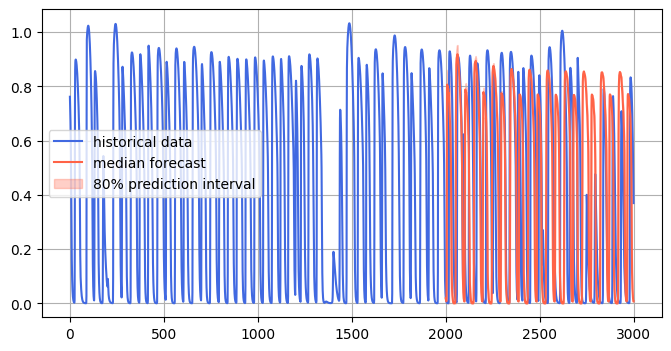

In [5]:

forecast_index = range(len(df), len(df) + p_length)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(voltage[:2000 + 1000], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [6]:
y_true = voltage[2000:2000 + 1000]          # NumPy array
y_pred = median.numpy()                       # convert TensorFlow tensor to NumPy

mse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print("RMSE:", mse)

RMSE: 0.5132209547713605


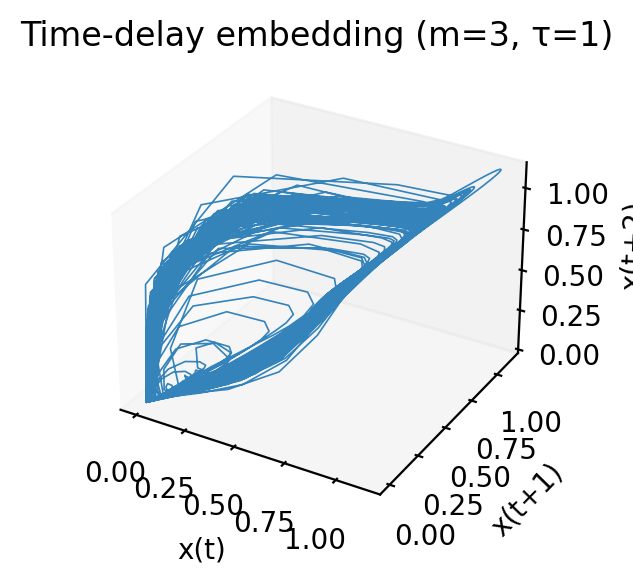

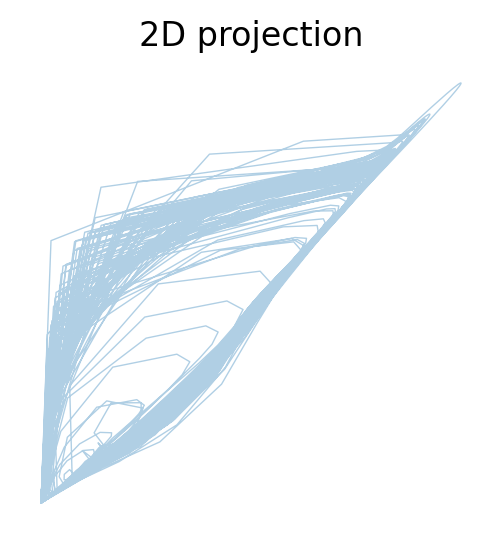

In [7]:
fig3d, fig2d = functions.plot_phase_from_1d(voltage, m=3, tau=1)


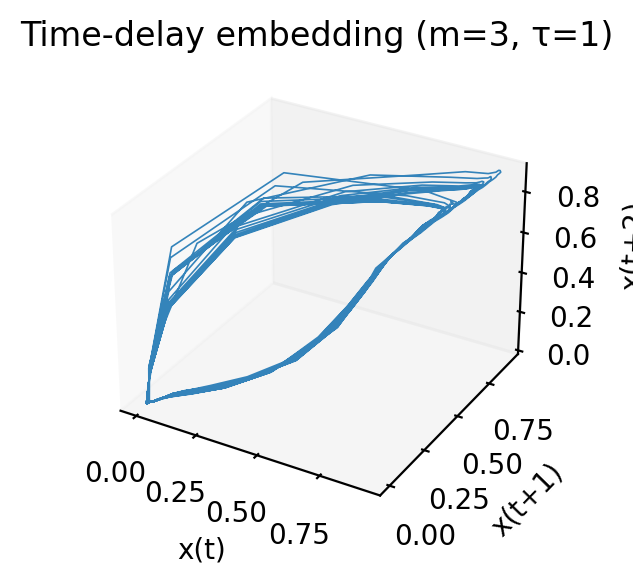

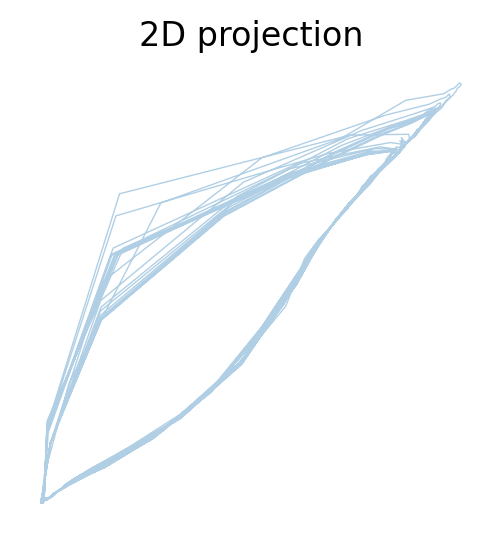

In [8]:
fig3d, fig2d = functions.plot_phase_from_1d(y_pred, m=3, tau=1)



TISEAN 3.0.0 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

d2: Estimates the correlation sum, -dimension and -entropy

Using output.dat as datafile!
Using columns: 1 
Use 1000 lines.


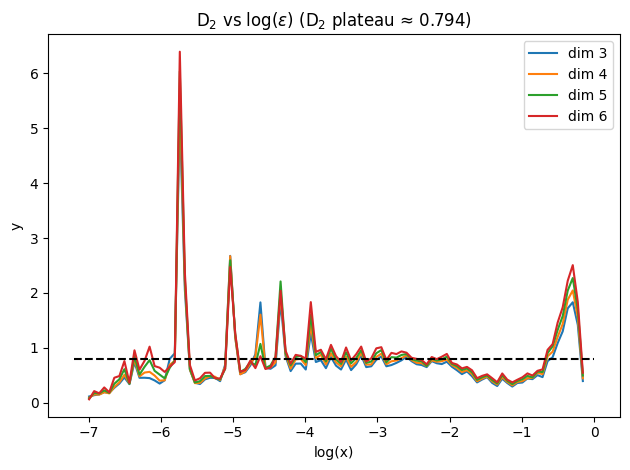

In [10]:
d2_lib = functions.cal_D2(y_pred,-3.5,-2)


TISEAN 3.0.0 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

d2: Estimates the correlation sum, -dimension and -entropy

Using output.dat as datafile!
Using columns: 1 
Use 5000 lines.


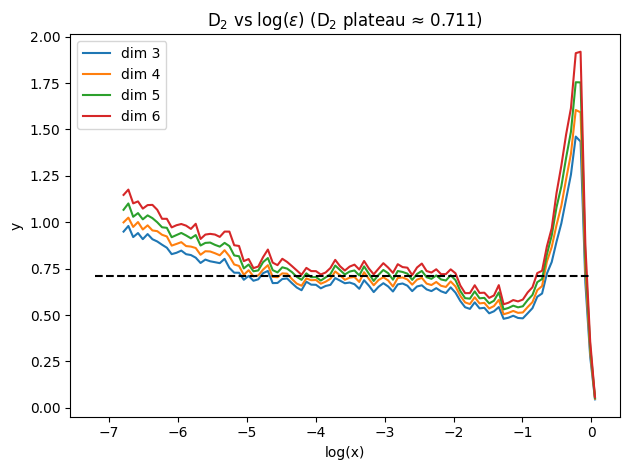

In [11]:
d2_lib = functions.cal_D2(voltage,-5,-2)